In [1159]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ionospheric-tec-data/van.csv
/kaggle/input/ionospheric-tec-data/5dec2018_codg2018-10-07to2018-12-05.csv
/kaggle/input/ionospheric-tec-data/out_epa_awaran_codg2013-07-27to2013-09-24.csv
/kaggle/input/ionospheric-tec-data/kour_gps_haiti.csv
/kaggle/input/ionospheric-tec-data/nepal_v2_gim.csv
/kaggle/input/ionospheric-tec-data/bogt_gps_haiti.csv
/kaggle/input/ionospheric-tec-data/glps_gps_haiti.csv
/kaggle/input/ionospheric-tec-data/in_epa_awaran_codg2013-07-27to2013-09-24_22-70.csv
/kaggle/input/ionospheric-tec-data/Jamaica_EQ_codg2019-11-30to2020-01-28_v3.csv
/kaggle/input/ionospheric-tec-data/iisc_bhuj.csv
/kaggle/input/ionospheric-tec-data/GIM2013-08-01to2013-10-15.csv
/kaggle/input/ionospheric-tec-data/14nov2019_codg2019-09-16to2019-11-14.csv
/kaggle/input/ionospheric-tec-data/Ridgecrest_EQ_codg2019-05-08to2019-07-06.csv
/kaggle/input/ionospheric-tec-data/Jamaica_EQ_codg2019-11-30to2020-01-28_v2.csv
/kaggle/input/ionospheric-tec-data/cro1_gps_haiti.csv


In [1160]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [1161]:
dataset = pd.read_csv("../input/ionospheric-tec-data/van.csv")
dataset_error_index = dataset
dataset.head(2)

,date,time,tec
0,01-Sep-2011,00:00:00,9.300214
1,01-Sep-2011,02:00:00,8.795906


In [1162]:
dataset['new_date'] = dataset['date'].str.cat(dataset['time'], sep =" ") 
dataset['new_date'] = pd.to_datetime(dataset['new_date'],format="%d-%b-%Y %H:%M:%S") #convert from string to datetime
selected_columns = ['new_date','tec']
dataset = dataset[selected_columns]

In [1163]:
train_df = dataset.loc[(dataset["new_date"] <= "2011-10-03 00:00:00")]
eval_df = dataset.loc[(dataset["new_date"] > "2011-10-02 00:00:00") & (dataset["new_date"] <= "2011-10-13 00:00:00")]
test_df = dataset.loc[(dataset["new_date"] > "2011-10-12 00:00:00") & (dataset["new_date"] <= "2011-10-25 00:00:00")]

In [1164]:
print("No. of observation in Data: ",dataset.shape)
print("No. of observation in Train Data: ",train_df.shape)
print("No. of observation in Eval Data: ",eval_df.shape)
print("No. of observation in Test Data: ",test_df.shape)
print("-----------------------------------------------")
print("Min of Train Date:", train_df.new_date.min())
print("Max of Train Date:", train_df.new_date.max())
print("Min of Eval Date:", eval_df.new_date.min())
print("Max of Eval Date:", eval_df.new_date.max())
print("Min of Test Date:", test_df.new_date.min())
print("Max of Test Date:", test_df.new_date.max())

No. of observation in Data:  (852, 2)
No. of observation in Train Data:  (385, 2)
No. of observation in Eval Data:  (132, 2)
No. of observation in Test Data:  (156, 2)
-----------------------------------------------
Min of Train Date: 2011-09-01 00:00:00
Max of Train Date: 2011-10-03 00:00:00
Min of Eval Date: 2011-10-02 02:00:00
Max of Eval Date: 2011-10-13 00:00:00
Min of Test Date: 2011-10-12 02:00:00
Max of Test Date: 2011-10-25 00:00:00


In [1165]:
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [1166]:
train_data = train_df.loc[:,'tec'].to_numpy()
print(train_data.shape) # 1258 


# Apply normalization before feeding to LSTM using sklearn:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)

scaler.fit(train_data)
train_data = scaler.transform(train_data)

(385,)


In [1167]:
# Create the data to train our model on:
time_steps = 12
X_train, y_train = create_dataset(train_data, time_steps)

# reshape it [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], time_steps, 1))

print(X_train.shape)


# Visualizing our data with prints: 
print('X_train:')
print(str(scaler.inverse_transform(X_train[0])))
print("\n")
print('y_train: ' + str(scaler.inverse_transform(y_train[0].reshape(-1,1)))+'\n')

(373, 12, 1)
X_train:
[[ 9.30021386]
 [ 8.79590614]
 [16.02897386]
 [23.43538771]
 [30.13222771]
 [29.41413386]
 [23.5914    ]
 [19.23926614]
 [19.60057386]
 [16.26714614]
 [11.21936   ]
 [10.82610614]]


y_train: [[10.27425386]]



In [1168]:
eval_data = eval_df.loc[:,'tec'].to_numpy()
print(eval_data.shape) 

scaler = MinMaxScaler()
eval_data = eval_data.reshape(-1,1)

scaler.fit(eval_data)
eval_data = scaler.transform(eval_data)

(132,)


In [1169]:
# Create the data to test our model on:
time_steps = 12
X_eval, y_eval = create_dataset(eval_data, time_steps)

# reshape it [samples, time steps, features]
X_eval = np.reshape(X_eval, (X_eval.shape[0], time_steps, 1))

print(X_eval.shape)


# Visualizing our data with prints: 
print('X_eval:')
print(str(scaler.inverse_transform(X_eval[0])))
print("\n")
print('y_eval: ' + str(scaler.inverse_transform(y_eval[0].reshape(-1,1)))+'\n')

(120, 12, 1)
X_eval:
[[10.97712   ]
 [18.90838614]
 [30.48191843]
 [35.09173386]
 [37.80525386]
 [35.31326614]
 [31.79955843]
 [23.31141229]
 [18.27693386]
 [15.05812   ]
 [13.18937386]
 [13.00090614]]


y_eval: [[11.67037386]]



In [1170]:
test_data = test_df.loc[:,'tec'].to_numpy()
print(test_data.shape) # 1258 

scaler = MinMaxScaler()
test_data = test_data.reshape(-1,1)

scaler.fit(test_data)
test_data = scaler.transform(test_data)

(156,)


In [1171]:
# Create the data to test our model on:
time_steps = 12
X_test, y_test = create_dataset(test_data, time_steps)

# reshape it [samples, time steps, features]
X_test = np.reshape(X_test, (X_test.shape[0], time_steps, 1))

print(X_test.shape)


# Visualizing our data with prints: 
print('X_test:')
print(str(scaler.inverse_transform(X_test[0])))
print("\n")
print('y_test: ' + str(scaler.inverse_transform(y_test[0].reshape(-1,1)))+'\n')

(144, 12, 1)
X_test:
[[11.96398771]
 [19.75196157]
 [31.08546614]
 [37.9388    ]
 [42.40209386]
 [38.76888   ]
 [32.04342614]
 [19.39875843]
 [13.6492    ]
 [13.56410614]
 [12.65968   ]
 [13.01478771]]


y_test: [[11.57004157]]



In [1172]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class BayesianLSTM(nn.Module):

    def __init__(self, n_features, output_length):

        super(BayesianLSTM, self).__init__()

        self.hidden_size_1 = 128
        self.hidden_size_2 = 32
        self.n_layers = 1 # number of (stacked) LSTM layers

        self.lstm1 = nn.LSTM(n_features, 
                             self.hidden_size_1, 
                             num_layers=1,
                             batch_first=True)
        self.lstm2 = nn.LSTM(self.hidden_size_1,
                             self.hidden_size_2,
                             num_layers=1,
                             batch_first=True)
        
        self.dense = nn.Linear(self.hidden_size_2, output_length)
        self.loss_fn = nn.MSELoss()
        
    def forward(self, x):
        batch_size, seq_len, _ = x.size()

        hidden = self.init_hidden1(batch_size)
        output, _ = self.lstm1(x, hidden)
        output = F.dropout(output, p=0.5, training=True)
        state = self.init_hidden2(batch_size)
        output, state = self.lstm2(output, state)
        output = F.dropout(output, p=0.5, training=True)
        output = self.dense(state[0].squeeze(0))
        
        return output
        
    def init_hidden1(self, batch_size):
        hidden_state = Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size_1))
        cell_state = Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size_1))
        return hidden_state, cell_state
    
    def init_hidden2(self, batch_size):
        hidden_state = Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size_2))
        cell_state = Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size_2))
        return hidden_state, cell_state
    
    def loss(self, pred, truth):
        return self.loss_fn(pred, truth)

    def predict(self, X):
        return self(torch.tensor(X, dtype=torch.float32)).view(-1).detach().numpy()

In [1173]:
n_features = 1
sequence_length = 12
output_length = 1

bayesian_lstm = BayesianLSTM(n_features=n_features,
                             output_length=output_length)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(bayesian_lstm.parameters(), lr=0.01)

batch_size = 12
n_epochs = 50

In [1174]:
bayesian_lstm.train()

for e in range(1, n_epochs+1):
    for b in range(0,len(X_train),batch_size):
        features = X_train[b:b+batch_size,:,:]
        target = y_train[b:b+batch_size]    

        X_batch = torch.tensor(features,dtype=torch.float32)    
        y_batch = torch.tensor(target,dtype=torch.float32)

        output = bayesian_lstm(X_batch) 
        loss = criterion(output.view(-1), y_batch)  

        loss.backward()
        optimizer.step()        
        optimizer.zero_grad() 

    if e % 10 == 0:
      print('epoch: ', e, 'loss: ', loss.item())

epoch:  10 loss:  0.001997040119022131
epoch:  20 loss:  0.00034871886600740254
epoch:  30 loss:  0.0004554562328848988
epoch:  40 loss:  0.0014902704861015081
epoch:  50 loss:  1.7417037270206492e-06


In [1175]:
offset = sequence_length

def inverse_transform(y):
  return scaler.inverse_transform(y.reshape(-1, 1))

In [1176]:
training_df = pd.DataFrame()
training_df['new_date'] = train_df['new_date'].iloc[offset:len(train_df) + offset:1]
training_df['actual_TEC'] = train_df['tec'].iloc[offset:len(train_df) + offset:1]
training_predictions = bayesian_lstm.predict(X_train)
training_predictions = inverse_transform(training_predictions)
training_df['predicted_TEC'] = training_predictions
training_df['new_date'] = pd.to_datetime(training_df['new_date'],format="%Y-%m-%d %H:%M:%S")
#training_df['new_date'] = training_df['new_date'].dt.strftime('%d-%m-%Y')
training_df = training_df.set_index(['new_date'])

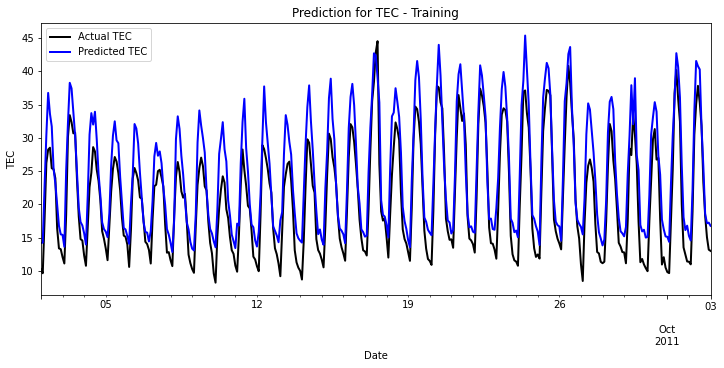

In [1177]:
# plot the results 
plt.figure(figsize=(12,5))
ax = plt.gca()
ax.set_facecolor('white')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y'))
#plt.plot(training_df['actual_TEC'], color = 'red', label = 'Actual TEC', linewidth=1.0)
training_df["actual_TEC"].plot(subplots=True, color='black', linewidth=2.0, label = "Actual TEC")
training_df["predicted_TEC"].plot(subplots=True, color='blue', linewidth=2.0, label = "Predicted TEC")
#plt.plot(training_df['predicted_TEC'], color = 'blue', label = 'Predicted TEC', linewidth=1.0)
plt.title('Prediction for TEC - Training')
plt.xlabel('Date')
plt.ylabel('TEC')
plt.legend()
plt.show()

In [1178]:
training_df.to_csv('training_df_epicentre_VAN.csv')

In [1179]:
evaling_df = pd.DataFrame()
evaling_df['new_date'] = eval_df['new_date'].iloc[offset::1]
evaling_df['actual_TEC'] = eval_df['tec'].iloc[offset::1]
evaling_predictions = bayesian_lstm.predict(X_eval)
evaling_predictions = inverse_transform(evaling_predictions)
evaling_df['predicted_TEC'] = evaling_predictions
evaling_df['new_date'] = pd.to_datetime(evaling_df['new_date'],format="%Y-%m-%d %H:%M:%S")
#evaling_df['new_date'] = evaling_df['new_date'].dt.strftime('%d-%m-%Y')
evaling_df = evaling_df.set_index(['new_date'])

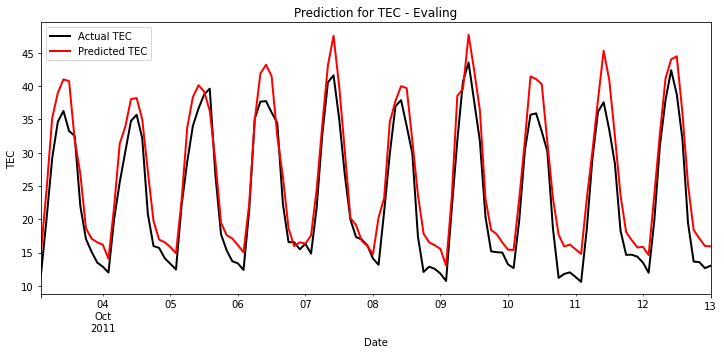

In [1180]:
# plot the results 
plt.figure(figsize=(12,5))
ax = plt.gca()
ax.set_facecolor('white')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y'))
#plt.plot(training_df['actual_TEC'], color = 'red', label = 'Actual TEC', linewidth=1.0)
evaling_df["actual_TEC"].plot(subplots=True, color='black', linewidth=2.0, label = "Actual TEC")
evaling_df["predicted_TEC"].plot(subplots=True, color='red', linewidth=2.0, label = "Predicted TEC")
#plt.plot(training_df['predicted_TEC'], color = 'blue', label = 'Predicted TEC', linewidth=1.0)
plt.title('Prediction for TEC - Evaling')
plt.xlabel('Date')
plt.ylabel('TEC')
plt.legend()
plt.show()

In [1181]:
from sklearn.metrics import mean_squared_error
from math import sqrt
org_eval_y = evaling_df["actual_TEC"]
predicted_eval_y = evaling_df["predicted_TEC"]
# evaluation model-1
mse = mean_squared_error(org_eval_y, predicted_eval_y)
rmse = sqrt(mse)
error_eval_data = abs(org_eval_y - predicted_eval_y)
evaling_df['error'] = error_eval_data
mean = np.mean(error_eval_data[0])
sd = np.std(error_eval_data)
print("Model-1 Evaluation\n-------------------------")
print("MSE:", mse )
print("RMSE:", rmse )
print("NMSE:", mse / (max(org_eval_y)-min(org_eval_y)))
print("NRMSE:", rmse / (max(org_eval_y)-min(org_eval_y)))
print("MEAN:", mean)
print("SD:", sd)
print("\n-------------------------")

Model-1 Evaluation
-------------------------
MSE: 14.257242739001045
RMSE: 3.7758764199853054
NMSE: 0.4326109844615136
NRMSE: 0.11457233668235287
MEAN: 3.464017924667969
SD: 1.831448885401395

-------------------------


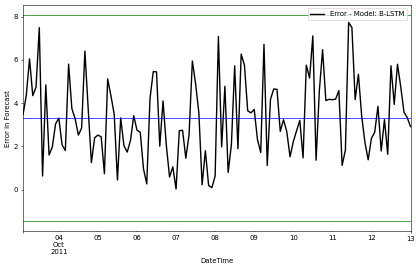

In [1182]:
plt.figure(figsize=(10,6),dpi=50)
ax = plt.gca()
ax.set_facecolor('white')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d'))
evaling_df["error"].plot(subplots=True, color='black', linewidth=2.0, label = "Error - Model: B-LSTM")
plt.axhline(y=np.mean(evaling_df['error']) + (2.6)*np.std(evaling_df['error']), color='g', linestyle='-', linewidth=1.0)
plt.axhline(y=np.mean(evaling_df['error']), color='blue', linestyle='-', linewidth=1.0)
plt.axhline(y=np.mean(evaling_df['error']) - (2.6)*np.std(evaling_df['error']), color='g', linestyle='-', linewidth=1.0)
#plt.axvline(x="2010-01-12 22:00:00", color='red', linestyle='-', linewidth=2.5, label = "Day of Earthquake : 2010-01-12 22:00:00")
#plt.title('Anomalies Detection - M 7.7 - 61km NNE of Awaran, Pakistan - LSTM')
plt.xlabel('DateTime')
plt.ylabel('Error in Forecast')
plt.legend()
plt.show()

In [1183]:
evaling_df.to_csv('evaling_df_epicentre_VAN.csv')

In [1184]:
testing_df = pd.DataFrame()
testing_df['new_date'] = test_df['new_date'].iloc[offset::1]
testing_df['actual_TEC'] = test_df['tec'].iloc[offset::1]
testing_predictions = bayesian_lstm.predict(X_test)
testing_predictions = inverse_transform(testing_predictions)
testing_df['predicted_TEC'] = testing_predictions
testing_df['new_date'] = pd.to_datetime(testing_df['new_date'],format="%Y-%m-%d %H:%M:%S")
#testing_df['new_date'] = testing_df['new_date'].dt.strftime('%d-%m-%Y')
testing_df = testing_df.set_index(['new_date'])

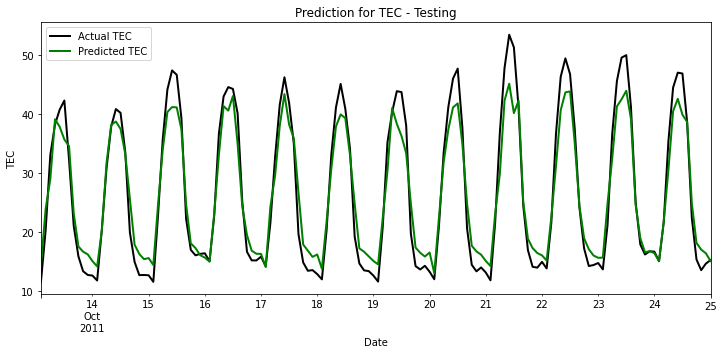

In [1185]:
# plot the results 
plt.figure(figsize=(12,5))
ax = plt.gca()
ax.set_facecolor('white')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y'))
#plt.plot(training_df['actual_TEC'], color = 'red', label = 'Actual TEC', linewidth=1.0)
testing_df["actual_TEC"].plot(subplots=True, color='black', linewidth=2.0, label = "Actual TEC")
testing_df["predicted_TEC"].plot(subplots=True, color='green', linewidth=2.0, label = "Predicted TEC")
#plt.plot(training_df['predicted_TEC'], color = 'blue', label = 'Predicted TEC', linewidth=1.0)
plt.title('Prediction for TEC - Testing')
plt.xlabel('Date')
plt.ylabel('TEC')
plt.legend()
plt.show()

In [1186]:
org_test_y = testing_df["actual_TEC"]
predicted_test_y = testing_df["predicted_TEC"]
error_test_data = org_test_y - predicted_test_y
testing_df['error'] = error_test_data

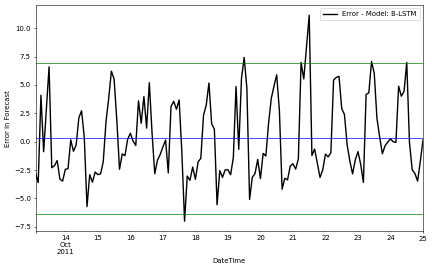

In [1216]:
plt.figure(figsize=(10,6),dpi=50)
ax = plt.gca()
ax.set_facecolor('white')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d'))
testing_df["error"].plot(subplots=True, color='black', linewidth=2.0, label = "Error - Model: B-LSTM")
plt.axhline(y=np.mean(testing_df['error']) + (3.64*np.std(evaling_df['error'])), color='g', linestyle='-', linewidth=1.0)
plt.axhline(y=np.mean(testing_df['error']), color='blue', linestyle='-', linewidth=1.0)
plt.axhline(y=np.mean(testing_df['error']) - (3.64*np.std(evaling_df['error'])), color='g', linestyle='-', linewidth=1.0)
#plt.axvline(x="2010-01-12 22:00:00", color='red', linestyle='-', linewidth=2.5, label = "Day of Earthquake : 2010-01-12 22:00:00")
#plt.title('Anomalies Detection - M 7.7 - 61km NNE of Awaran, Pakistan - LSTM')
plt.xlabel('DateTime')
plt.ylabel('Error in Forecast')
plt.legend()
plt.show()

In [1188]:
testing_df.to_csv('testing_df_epicentre_VAN.csv')

In [1189]:
n_experiments = 100

test_uncertainty_df = pd.DataFrame()
test_uncertainty_df['new_date'] = test_df['new_date'].iloc[offset::1]
for i in range(n_experiments):
  experiment_predictions = bayesian_lstm.predict(X_test)
  test_uncertainty_df['tec_{}'.format(i)] = inverse_transform(experiment_predictions)

tec_df = test_uncertainty_df.filter(like='tec', axis=1)
test_uncertainty_df['actual_tec'] = test_df['tec']
test_uncertainty_df['predicted_tec'] = testing_predictions
test_uncertainty_df['tec_mean'] = tec_df.mean(axis=1)
test_uncertainty_df['tec_std'] = tec_df.std(axis=1)

test_uncertainty_df = test_uncertainty_df[['new_date', 'actual_tec', 'predicted_tec', 'tec_mean', 'tec_std']]
test_uncertainty_df = test_uncertainty_df.set_index(['new_date'])

In [1190]:
test_uncertainty_df['lower_bound'] = test_uncertainty_df['tec_mean'] - (2.6)*test_uncertainty_df['tec_std']
test_uncertainty_df['upper_bound'] = test_uncertainty_df['tec_mean'] + (2.6)*test_uncertainty_df['tec_std']

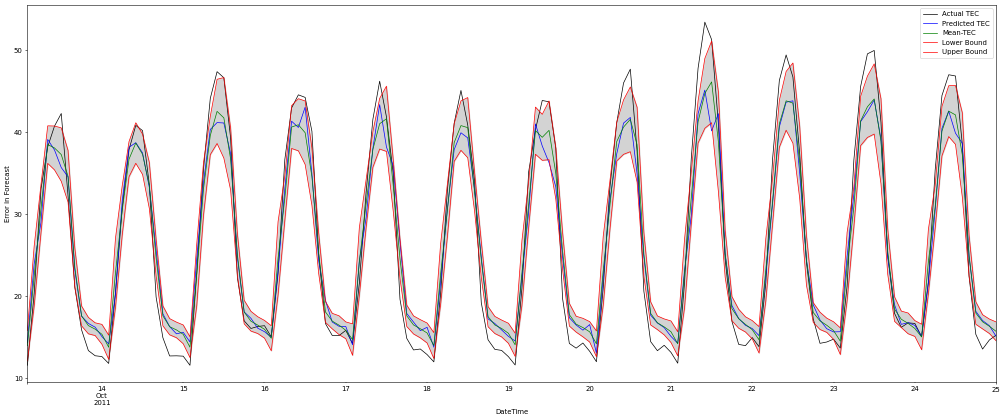

In [1191]:
plt.figure(figsize=(25,10),dpi=50)
ax = plt.gca()
ax.set_facecolor('white')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d'))
test_uncertainty_df["actual_tec"].plot(subplots=True, color='black', linewidth=1.0, label = "Actual TEC")
test_uncertainty_df["predicted_tec"].plot(subplots=True, color='blue', linewidth=1.0, label = "Predicted TEC")
test_uncertainty_df["tec_mean"].plot(subplots=True, color='g', linewidth=1.0, label = "Mean-TEC")
test_uncertainty_df["lower_bound"].plot(subplots=True, color='red', linewidth=1.0, label = "Lower Bound")
test_uncertainty_df["upper_bound"].plot(subplots=True, color='red', linewidth=1.0, label = "Upper Bound")
#plt.axvline(x="2010-01-12 22:00:00", color='red', linestyle='-', linewidth=2.5, label = "Day of Earthquake : 2010-01-12 22:00:00")
#plt.title('Anomalies Detection - M 7.7 - 61km NNE of Awaran, Pakistan - LSTM')
plt.fill_between(test_uncertainty_df.index,test_uncertainty_df["upper_bound"],test_uncertainty_df["lower_bound"],interpolate=True,color='lightgrey')
plt.xlabel('DateTime')
plt.ylabel('Error in Forecast')
plt.legend()
plt.show()

In [1192]:
test_uncertainty_df['is_not_error'] = ((test_uncertainty_df['predicted_tec'] >= test_uncertainty_df['lower_bound']) &
                          (test_uncertainty_df['predicted_tec'] <= test_uncertainty_df['upper_bound']))

In [1193]:
test_anomaly_uncertainty_df = pd.DataFrame()
test_anomaly_uncertainty_df = test_uncertainty_df.loc[(test_uncertainty_df['is_not_error']==False)]
test_anomaly_uncertainty_df.head()

,actual_tec,predicted_tec,tec_mean,tec_std,lower_bound,upper_bound,is_not_error
new_date,,,,,,,
2011-10-16 18:00:00,16.646918,19.485945,18.069189,0.488845,16.798191,19.340187,False
2011-10-19 12:00:00,43.698866,36.273808,40.218632,1.378281,36.635101,43.802162,False
2011-10-21 12:00:00,51.282226,40.142895,46.127460,1.914906,41.148705,51.106216,False


In [1194]:
test_error_uncertainty_df = pd.DataFrame()
test_error_uncertainty_df['error'] = test_anomaly_uncertainty_df['predicted_tec']
#test_error_uncertainty_df['error_intensity'] = test_anomaly_uncertainty_df['actual_tec']
for i in range(0,len(test_anomaly_uncertainty_df)):
    #test_anomaly_uncertainty_df['predicted_tec'].iloc[i]
    if (test_anomaly_uncertainty_df['predicted_tec'].iloc[i]<test_anomaly_uncertainty_df['lower_bound'].iloc[i]):
        test_error_uncertainty_df['error'].iloc[i] = test_anomaly_uncertainty_df['predicted_tec'].iloc[i] - test_anomaly_uncertainty_df['lower_bound'].iloc[i]
    if (test_anomaly_uncertainty_df['predicted_tec'].iloc[i]>test_anomaly_uncertainty_df['upper_bound'].iloc[i]):
        test_error_uncertainty_df['error'].iloc[i] = test_anomaly_uncertainty_df['predicted_tec'].iloc[i] - test_anomaly_uncertainty_df['upper_bound'].iloc[i]

In [1195]:
test_error_uncertainty_df['error_intensity'] = test_anomaly_uncertainty_df['actual_tec']
for i in range(0,len(test_anomaly_uncertainty_df)):
    #test_anomaly_uncertainty_df['predicted_tec'].iloc[i]
    if (test_anomaly_uncertainty_df['predicted_tec'].iloc[i]<test_anomaly_uncertainty_df['lower_bound'].iloc[i]):
        test_error_uncertainty_df['error_intensity'].iloc[i] = ((test_anomaly_uncertainty_df['predicted_tec'].iloc[i] - test_anomaly_uncertainty_df['lower_bound'].iloc[i])/test_anomaly_uncertainty_df['lower_bound'].iloc[i])*100
    if (test_anomaly_uncertainty_df['predicted_tec'].iloc[i]>test_anomaly_uncertainty_df['upper_bound'].iloc[i]):
        test_error_uncertainty_df['error_intensity'].iloc[i] = ((test_anomaly_uncertainty_df['predicted_tec'].iloc[i] - test_anomaly_uncertainty_df['upper_bound'].iloc[i])/test_anomaly_uncertainty_df['upper_bound'].iloc[i])*100

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [1196]:
test_anomaly_uncertainty_df

,actual_tec,predicted_tec,tec_mean,tec_std,lower_bound,upper_bound,is_not_error
new_date,,,,,,,
2011-10-16 18:00:00,16.646918,19.485945,18.069189,0.488845,16.798191,19.340187,False
2011-10-19 12:00:00,43.698866,36.273808,40.218632,1.378281,36.635101,43.802162,False
2011-10-21 12:00:00,51.282226,40.142895,46.127460,1.914906,41.148705,51.106216,False


In [1197]:
test_error_uncertainty_df['actual_tec'] = test_anomaly_uncertainty_df['actual_tec']
test_error_uncertainty_df = test_error_uncertainty_df[['error','error_intensity']]
test_error_uncertainty_df

,error,error_intensity
new_date,,
2011-10-16 18:00:00,0.145758,0.753652
2011-10-19 12:00:00,-0.361294,-0.986196
2011-10-21 12:00:00,-1.005810,-2.444329


**error based**

In [1198]:
n_experiments = 100
e_test_uncertainty_df = pd.DataFrame()
e_test_uncertainty_df['new_date'] = test_df['new_date'].iloc[offset::1]
e_test_uncertainty_df['tec'] = test_df['tec'].iloc[offset::1]
for i in range(n_experiments):
  experiment_predictions = bayesian_lstm.predict(X_test)
  e_test_uncertainty_df['tec_{}'.format(i)] = inverse_transform(experiment_predictions)
  e_test_uncertainty_df['eTEC_{}'.format(i)] = e_test_uncertainty_df['tec'] - e_test_uncertainty_df['tec_{}'.format(i)]


In [1199]:
#testing_df = testing_df.reset_index(drop=True)
#testing_df.reset_index(inplace=True)
e_test_uncertainty_df['error'] = np.array(testing_df['error'])

In [1200]:
e_tec_df = e_test_uncertainty_df.filter(like='eTEC', axis=1)
e_test_uncertainty_df['e_tec_mean'] = e_tec_df.mean(axis=1)
e_test_uncertainty_df['e_tec_std'] = e_tec_df.std(axis=1)
e_test_uncertainty_df = e_test_uncertainty_df[['new_date', 'error', 'e_tec_mean', 'e_tec_std']]

In [1201]:
e_test_uncertainty_df['e_lower_bound'] = e_test_uncertainty_df['e_tec_mean'] - (2.6)*e_test_uncertainty_df['e_tec_std']
e_test_uncertainty_df['e_upper_bound'] = e_test_uncertainty_df['e_tec_mean'] + (2.6)*e_test_uncertainty_df['e_tec_std']

In [1202]:
e_test_uncertainty_df = e_test_uncertainty_df.set_index(['new_date'])

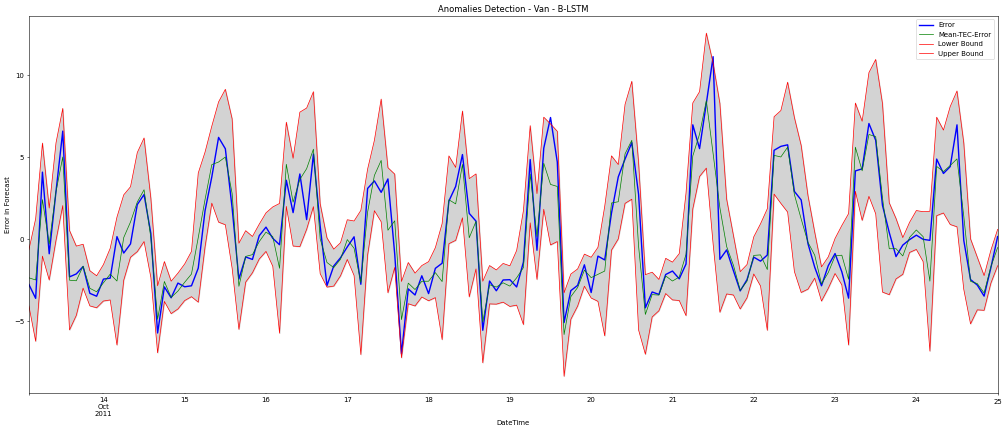

In [1203]:
plt.figure(figsize=(25,10),dpi=50)
ax = plt.gca()
ax.set_facecolor('white')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y'))
e_test_uncertainty_df["error"].plot(subplots=True, color='blue', linewidth=2.0, label = "Error")
e_test_uncertainty_df["e_tec_mean"].plot(subplots=True, color='g', linewidth=1.0, label = "Mean-TEC-Error")
e_test_uncertainty_df["e_lower_bound"].plot(subplots=True, color='red', linewidth=1.0, label = "Lower Bound")
e_test_uncertainty_df["e_upper_bound"].plot(subplots=True, color='red', linewidth=1.0, label = "Upper Bound")
#plt.axvline(x=54, color='red', linestyle='-', linewidth=2.5, label = "Day of Earthquake : 2010-01-12 22:00:00")
plt.title('Anomalies Detection - Van - B-LSTM')
plt.fill_between(e_test_uncertainty_df.index,e_test_uncertainty_df["e_upper_bound"],e_test_uncertainty_df["e_lower_bound"],interpolate=True,color='lightgrey')
plt.xlabel('DateTime')
plt.ylabel('Error in Forecast')
plt.legend()
plt.show()

In [1204]:
e_test_uncertainty_df['is_not_error'] = ((e_test_uncertainty_df['error'] >= e_test_uncertainty_df['e_lower_bound']) &
                          (e_test_uncertainty_df['error'] <= e_test_uncertainty_df['e_upper_bound']))

In [1205]:
e_test_uncertainty_df.to_csv('e_test_uncertainty_df_epicentre_VAN.csv')

In [1206]:
e_test_anomaly_uncertainty_df = pd.DataFrame()
e_test_anomaly_uncertainty_df = e_test_uncertainty_df.loc[(e_test_uncertainty_df['is_not_error']==False)]
e_test_anomaly_uncertainty_df.head()

,error,e_tec_mean,e_tec_std,e_lower_bound,e_upper_bound,is_not_error
new_date,,,,,,
2011-10-19 12:00:00,7.425059,3.339253,1.421044,-0.355461,7.033967,False
2011-10-21 12:00:00,11.139331,5.221815,2.121719,-0.294656,10.738286,False


In [1207]:
e_test_error_uncertainty_df = pd.DataFrame()
e_test_error_uncertainty_df['error'] = e_test_anomaly_uncertainty_df['error']
#test_error_uncertainty_df['error_intensity'] = test_anomaly_uncertainty_df['actual_tec']
for i in range(0,len(e_test_anomaly_uncertainty_df)):
    #test_anomaly_uncertainty_df['predicted_tec'].iloc[i]
    if (e_test_anomaly_uncertainty_df['error'].iloc[i]<e_test_anomaly_uncertainty_df['e_lower_bound'].iloc[i]):
        e_test_error_uncertainty_df['error'].iloc[i] = (abs(e_test_anomaly_uncertainty_df['error'].iloc[i]) - abs(e_test_anomaly_uncertainty_df['e_lower_bound'].iloc[i]))
    if (e_test_anomaly_uncertainty_df['error'].iloc[i]>e_test_anomaly_uncertainty_df['e_upper_bound'].iloc[i]):
        e_test_error_uncertainty_df['error'].iloc[i] = (abs(e_test_anomaly_uncertainty_df['e_upper_bound'].iloc[i])-abs(e_test_anomaly_uncertainty_df['error'].iloc[i]))

In [1221]:
e_test_error_uncertainty_df['error_intensity'] = e_test_anomaly_uncertainty_df['error']
for i in range(0,len(e_test_anomaly_uncertainty_df)):
    #test_anomaly_uncertainty_df['predicted_tec'].iloc[i]
    if (e_test_anomaly_uncertainty_df['error'].iloc[i]<e_test_anomaly_uncertainty_df['e_lower_bound'].iloc[i]):
        e_test_error_uncertainty_df['error_intensity'].iloc[i] = ((  abs(e_test_anomaly_uncertainty_df['error'].iloc[i])   -  abs(e_test_anomaly_uncertainty_df['e_lower_bound'].iloc[i])) /abs(e_test_anomaly_uncertainty_df['e_lower_bound'].iloc[i]))*(-100)
    if (e_test_anomaly_uncertainty_df['error'].iloc[i]>e_test_anomaly_uncertainty_df['e_upper_bound'].iloc[i]):
        e_test_error_uncertainty_df['error_intensity'].iloc[i] = ((abs(e_test_anomaly_uncertainty_df['error'].iloc[i])-abs(e_test_anomaly_uncertainty_df['e_upper_bound'].iloc[i]))/abs(e_test_anomaly_uncertainty_df['e_upper_bound'].iloc[i]))*(100)

In [1222]:
e_test_error_uncertainty_df['error'] = e_test_anomaly_uncertainty_df['error']
e_test_error_uncertainty_df = e_test_error_uncertainty_df[['error','error_intensity']]
e_test_error_uncertainty_df

,error,error_intensity
new_date,,
2011-10-19 12:00:00,7.425059,5.560047
2011-10-21 12:00:00,11.139331,3.734728


In [1223]:
e_test_error_uncertainty_df.to_csv('e_test_error_uncertainty_df_epicentre_VAN.csv')